# Store item demand forecasting
In this project, I will build a machine learning model to forecast 3 months of 50 items sales in 10 different stores of a company. It involves supervised learning, using a labeled training set for time series forecasting.

I will use the following pipeline, based on CRISP-DM framework:

1. Business understanding
2. Data understanding
3. Data preparation
4. Modelling
5. Evaluation
6. Deployment

In this notebook, I will be covering steps 3 to 6 of the pipeline above. The main objective here is to build a model capable of accurately forecasting sales for 50 items across 10 stores over a three-month period, interpreting its outcomes and determining financial results. Furthermore, I will approach these steps in detail below, explaining why I am making each decision.

### Importing the libraries

In [32]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor

# Warnings filtering.
import warnings
warnings.filterwarnings('ignore')

# Plot grid styles.
sns.set_theme(style='whitegrid')

### Reading the dataset

In [33]:
df_raw = pd.read_csv('data/train.csv')

In [34]:
df_raw.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


I will convert the date column to the correct data type (datetime) and set it as the dataset index in order to turn the modelling step easier. In a forecasting task, the date column is very important. From the dates, other time series features will be created and we will be able to visualize the sales trends, seasonal patterns and characteristics over time. 

In [35]:
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_raw.set_index('date', inplace=True)
df_raw.sort_values(by=['date', 'store', 'item'], inplace=True)
df_raw.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-01,1,2,33
2013-01-01,1,3,15
2013-01-01,1,4,10
2013-01-01,1,5,11


In [36]:
print(f'The data goes from {df_raw.index.min()} to {df_raw.index.max()}.')

The data goes from 2013-01-01 00:00:00 to 2017-12-31 00:00:00.


### Time series cross validation
- Time series data is a sequence of data points indexed in time order, typically at uniform intervals.
- We cannot choose random samples and assign them to either training or validation sets as it makes no sense in using the values from the future data to predict values of the past data.
- We split the data into training and validation set according to time - "forward chaining" method or rolling/extending cross-validation
- We start with a subset of data as the training set. Based on that set we predict later data points and then check the score. The Predicted samples are then included as part of the next training dataset and subsequent samples are forecasted.
- I will use sklearn TimeSeriesSplit to apply time series cross validation. This technique will allow us to assess the model's ability to generalize to unseen data points in the future, comparing different models trained on distinct data preparation approaches.

Defining a function to assess wheter the time series split was correctly made.

In [37]:
def time_series_cv_report(data, test_size, gap, target, n_splits=5):
    # Getting sklearn TimeSeriesSplit object to obtain train and validation chronological indexes at each fold.
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=gap)

    fig, axes = plt.subplots(n_splits, 1, figsize=(20, 8), sharex=True, sharey=True)

    for fold, (train_index, val_index) in enumerate(tscv.split(data)):
        # Printing train and validation indexes at each fold.
        print('-'*30)
        print(f'Fold {fold}')
        print(f'Train: {train_index[0]} to {train_index[-1]}')
        print(f'Validation: {val_index[0]} to {val_index[-1]}')

        # Plotting the Time Series Split at each fold.
        axes[fold].plot(data.index, data[target], label='Complete Data', color='green')
        axes[fold].plot(data.iloc[train_index].index, data[target].iloc[train_index], label='Train')
        axes[fold].plot(data.iloc[val_index].index, data[target].iloc[val_index], label='Validation')

        axes[fold].set_title(f'Fold {fold} Time Series Split')
        axes[fold].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

Defining a function to obtain time series cross validation scores for a model.

In [63]:
def time_series_cv(data, model, test_size, gap, target, n_splits=5, log=False, verbose=False):
    # Getting sklearn TimeSeriesSplit object to obtain train and validation chronological indexes at each fold.
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=gap)

    scores = []
    for fold, (train_index, val_index) in enumerate(tscv.split(df_raw)):
        # Obtaining train and validation data at fold k.
        train = data.iloc[train_index]
        val = data.iloc[val_index]

        # Obtaining predictor and target train and validation sets.
        X_train = train.drop(columns=[target])
        y_train = train[target].copy()
        X_val = val.drop(columns=[target])
        y_val = val[target].copy()

        # Fitting the model to the training data.
        model.fit(X_train, y_train)

        # Prediction on validation data.
        y_pred = model.predict(X_val)

        # Obtaining the validation score at fold k.
        if log:
            score = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))
        else:
            score = np.sqrt(mean_squared_error(y_val, y_pred))
        
        scores.append(score)

        # Printing the results and returning scores array.

        if verbose:
            print('-'*40)
            print(f'Fold {fold}')
            print(f'Score (RMSE) = {round(score, 4)}')
            
    print('-'*60)
    print(f"{type(model).__name__}'s time series cross validation results:")
    print(f'Average validation score = {round(np.mean(scores), 4)}')
    print(f'Standard deviation = {round(np.std(scores), 4)}')

    return scores

Let's see wheter the time series split is being correctly made. Considering that we want to forecast 3 months of future sales for 50 items at 10 different stores and the sales are recorded daily, I will define a test size of 1x93x50x10. Moreover, I will define a one week gap between train and test sets in order to avoid overfitting. A 7 days gap will be a period of 1x7x50x10.

------------------------------
Fold 0
Train: 0 to 676999
Validation: 680500 to 726999


------------------------------
Fold 1
Train: 0 to 723499
Validation: 727000 to 773499
------------------------------
Fold 2
Train: 0 to 769999
Validation: 773500 to 819999
------------------------------
Fold 3
Train: 0 to 816499
Validation: 820000 to 866499
------------------------------
Fold 4
Train: 0 to 862999
Validation: 866500 to 912999


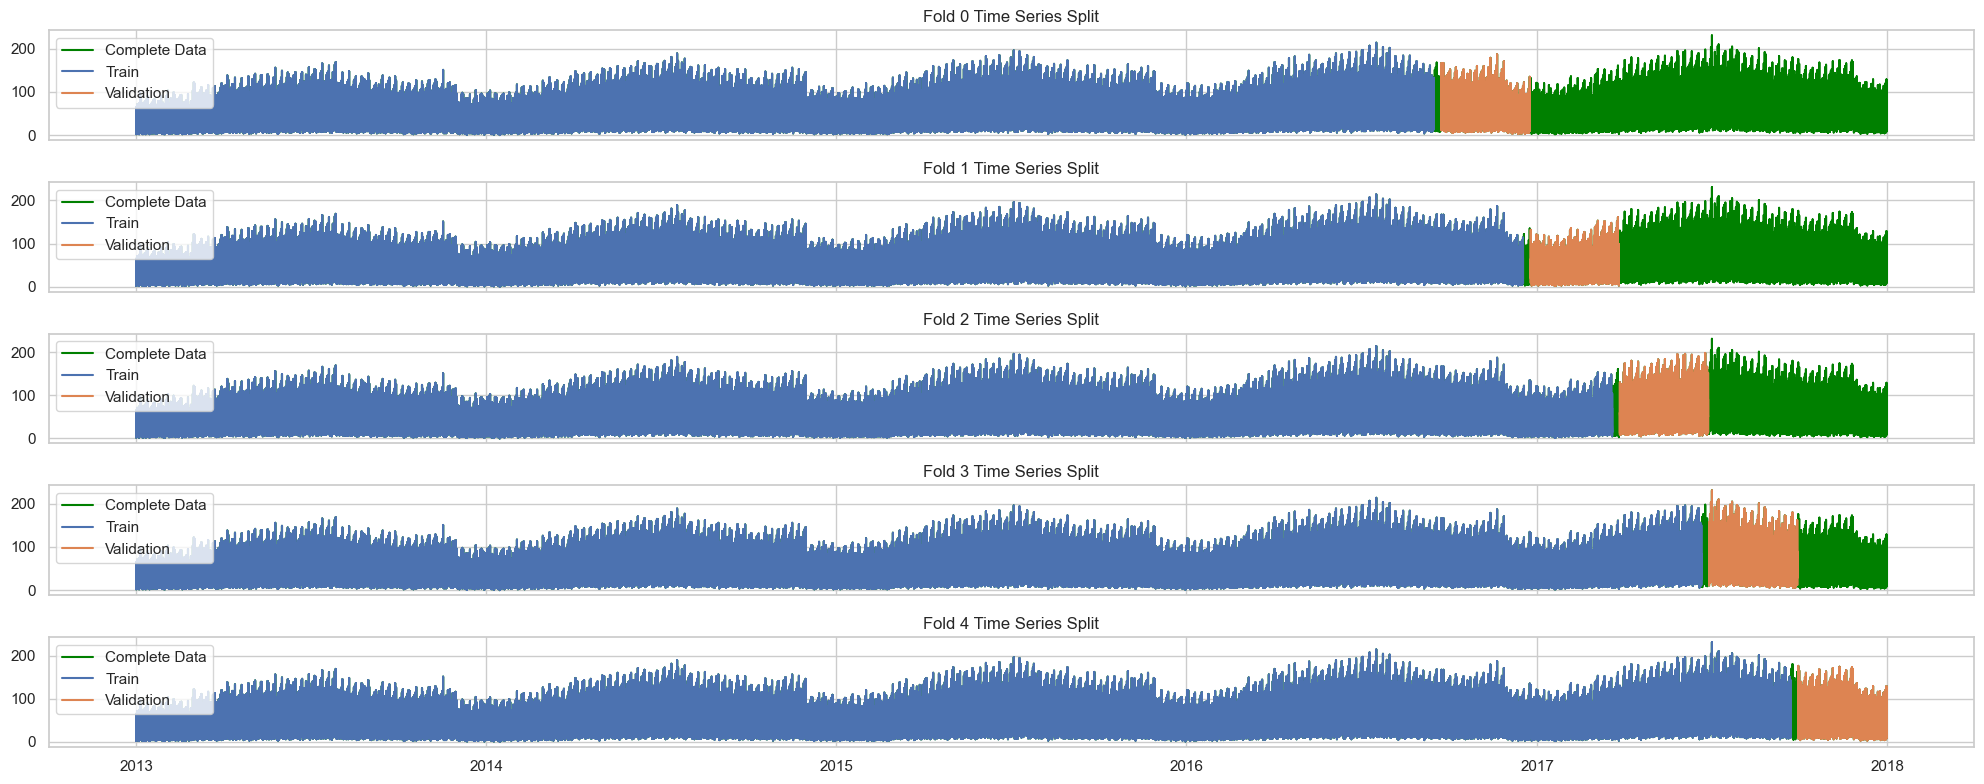

In [39]:
TEST_SIZE, GAP, TARGET = 1*93*50*10, 1*7*50*10, 'sales'
time_series_cv_report(df_raw, test_size=TEST_SIZE, gap=GAP, target=TARGET, n_splits=5)

Let's take a look at the train and validation sets for fold 0 to confirm that indeed the time series split is being made correctly.

In [40]:
train, val = df_raw.iloc[0:676999+1], df_raw.iloc[680500:726999+1]
train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-01,1,2,33
2013-01-01,1,3,15
2013-01-01,1,4,10
2013-01-01,1,5,11


In [41]:
train.tail()

,store,item,sales
date,,,
2016-09-15,10,46,65
2016-09-15,10,47,30
2016-09-15,10,48,61
2016-09-15,10,49,41
2016-09-15,10,50,78


In [42]:
val.head()

,store,item,sales
date,,,
2016-09-23,1,1,24
2016-09-23,1,2,60
2016-09-23,1,3,36
2016-09-23,1,4,32
2016-09-23,1,5,19


In [43]:
val.tail()

,store,item,sales
date,,,
2016-12-24,10,46,64
2016-12-24,10,47,24
2016-12-24,10,48,52
2016-12-24,10,49,49
2016-12-24,10,50,65


Clearly, the time series split is indeed correct! It is possible to see that training data covers the 50 items sales for stores 1 to 10 across a time period while validation set starts a week after this time period, covering the 50 items sales for stores 1 to 10.

# 4. Data preparation
- In this step, I will do all the data preparation, like feature engineering, train-test split and data preprocessing. 
- I will be turning back to this phase after modelling in order to test different approaches (from simpler to more complex ones) until the best performance is achieved in a crisp-dm data preparation / modelling cycle. Thus, I will enumerate the distinct data preparations and modelling approaches I will test. This enumeration will represent the experiments sequence. For example, a model trained with a data preparation made in 4.2 will be in section 5.2.
- I will use time series cross validation to evaluate the model trained on different approaches of data preparation and modelling. By doing this, I will obtain a more reliable performance indicator. Moreover, this will enable me to use the test set only to evaluate the final model, simulating production data. 
- I intend to use LightGBM for the sales forecasting because I am focusing on the predictive power. LightGBM offers fast training and high predictive power by using the gradient boosting framework. Furthermore, with its early stopping parameter, it is possible to avoid overfitting by stopping the training when the validation error stops to decrease while the training error would keep decreasing. This is the moment where overfitting starts.
- Tree-based models like LightGBM don't require feature scaling. Thus, I will not scale the data.
- Time series features like dayofweek and weeokfyear already present ordinal relationships, allowing the ensembles to capture seasonality and so on. Thus, it may not be an advantage encoding them. One-hot encoding, for example, would damage trees performance due to sparse representation and dimensionality increase. 
- Although they are in numeric data type, features like store and item present categorical behaviour and could be encoded. Initially, I don't intend to perform any transformation to these features. However, as I said, I will test different approaches.
- LightGBM already deals with missing values, so, when creating features like lags, I will not treat them.
- The outliers were investigated in the EDA step. Once they don't represent iconsistent information, I will not treat them.
- For time series forecasting, a bunch of features can be created, including date-related features, lag features, rolling statistics, holiday indicators, time-based aggregations and so on. I will test them below.
- Considering that sales variable is significantly right-skewed, a log-transformation can be applied to normalize it, turning it more symmetric. I will test it below.

### 4.1.0 Baseline
Below I will start with a baseline data preparation and modelling. Then, I will try to enhance this baseline model performance.

### 4.1.1 Basic feature engineering
Initially, let's create basic date-related time series features. 

In [44]:
def create_date_features(data):
    
    df = data.copy()
    
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(np.float64)
    df['is_wknd'] = df.index.weekday // 4
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)

    return df

In [45]:
df_date = create_date_features(df_raw)
df_date.head()

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_wknd,is_month_start,is_month_end
date,,,,,,,,,,,,,
2013-01-01,1,1,13,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,2,33,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,3,15,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,4,10,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,5,11,1,1,1,2013,1,1,1.0,0,1,0


### 4.2.0 Log Transformation
Considering that sales variable is significantly right-skewed (I found this on EDA step), I will apply a log transformation to it in order to turn it more symmetric. By doing this, the model will better capture the patterns behind the data. An important observation here is that there are records with zero sales. Thus, I will add a constant (1) to the log transformation.

In [46]:
df_log = df_raw.copy()
df_log['sales'] = np.log1p(df_log['sales'])
df_log = create_date_features(df_log)
df_log.head()

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_wknd,is_month_start,is_month_end
date,,,,,,,,,,,,,
2013-01-01,1,1,2.639057,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,2,3.526361,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,3,2.772589,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,4,2.397895,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,5,2.484907,1,1,1,2013,1,1,1.0,0,1,0


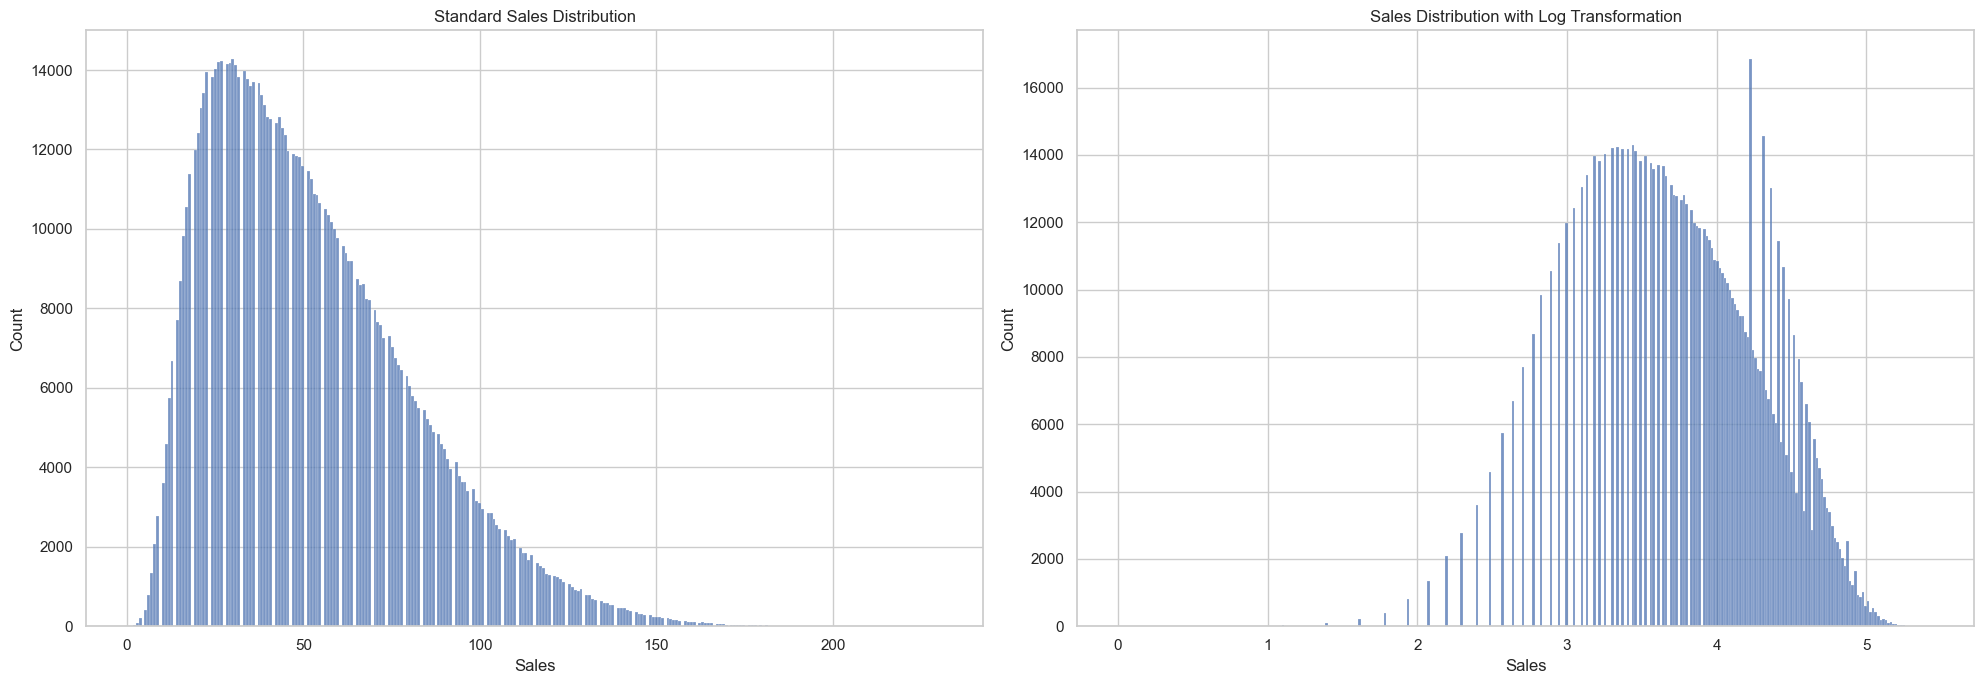

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax0 = sns.histplot(data=df_raw, x='sales', ax=ax[0])
ax0.set_title('Standard Sales Distribution')
ax0.set_xlabel('Sales')
ax0.set_ylabel('Count')

ax1 = sns.histplot(data=df_log, x='sales', ax=ax[1])
ax1.set_title('Sales Distribution with Log Transformation')
ax1.set_xlabel('Sales')
ax1.set_ylabel('Count')

plt.tight_layout()
plt.show()

By applying log transformation to sales variable, its distribution becomes more symmetric, allowing the model to better capture the patterns behind the data.

### 4.2.1 Lag features
- Lag features are the past observations of a time series variable used as input features for predicting future values.
- Incorporating lag features enables the model to capture temporal dependencies and patterns within the time series data.
- The lag value we choose will depend on the correlation of individual values with its past values.
- A way to determining the lag at which the correlation is significant is using the ACF (autocorrelation function) and PACF (partial autocorrelation function) plots. 
- ACF: The ACF plot is a measure of the correlation between the time series and the lagged version of itself
- PACF: The PACF plot is a measure of the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons
- I will add sales lag features from 3 months, 3 months and some weeks, six months, a year, a year and a half and 2 years in the past. I will do this because we are trying to forecast 3 months of sales and the data presents weekly seasonality (sales are higher on sunday), monthly seasonality (sales are higher on july) and an yearly increase trend.

First, it is necessary to sort the values by store, item and date. By doing this, we can get the correct lags - a lag for an item sales at a store will be the past sales values for the same item and store.

In [48]:
df_log.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
df_log.head()

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_wknd,is_month_start,is_month_end
date,,,,,,,,,,,,,
2013-01-01,1,1,2.639057,1,1,1,2013,1,1,1.0,0,1,0
2013-01-02,1,1,2.484907,2,1,1,2013,2,2,1.0,0,0,0
2013-01-03,1,1,2.708050,3,1,1,2013,3,3,1.0,0,0,0
2013-01-04,1,1,2.639057,4,1,1,2013,4,4,1.0,1,0,0
2013-01-05,1,1,2.397895,5,1,1,2013,5,5,1.0,1,0,0


Defining a function to create the lags.

In [49]:
def create_lag_features(data, lags):
    df = data.copy()
    for lag in lags:
        df['sales_lag_' + str(lag)] = df.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(lag))
    
    return df

In [50]:
lags = [91, 98, 105, 112, 119, 126, 182, 364, 546, 728]
df_log = create_lag_features(df_log, lags=lags)
# Turning back to ordered date values, necessary for time series cross validation.
df_log.sort_values(by=['date', 'store', 'item'], inplace=True)
df_log.head()

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,2.639057,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,2,3.526361,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,3,2.772589,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,4,2.397895,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,5,2.484907,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
df_log.tail()

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
date,,,,,,,,,,,,,,,,,,,,,
2017-12-31,10,46,4.262680,6,4,12,2017,365,31,52.0,...,4.219508,4.532599,4.418841,4.634729,4.543295,4.574711,4.595120,4.276666,4.663439,3.951244
2017-12-31,10,47,3.135494,6,4,12,2017,365,31,52.0,...,3.526361,3.496508,3.433987,3.496508,3.401197,3.784190,3.688879,3.295837,3.761200,2.995732
2017-12-31,10,48,4.110874,6,4,12,2017,365,31,52.0,...,4.330733,4.454347,4.394449,4.605170,4.369448,4.564348,4.682131,3.988984,4.624973,3.970292
2017-12-31,10,49,3.761200,6,4,12,2017,365,31,52.0,...,3.688879,3.806662,3.850148,3.637586,3.891820,4.007333,4.094345,3.761200,4.234107,3.496508
2017-12-31,10,50,4.418841,6,4,12,2017,365,31,52.0,...,4.605170,4.605170,4.682131,4.574711,4.634729,4.762174,4.795791,4.248495,4.820282,4.406719


The lags were succesfully created! The initial values in the data will contain NaN's, once there is not 91 days or more past data available. Since LightGBM deals with missing values, I will not impute or treat them. Let's check autocorrelation (ACF) and partial autocorrelation (PACF) functions in order to assess wheter this lags are useful for the model.

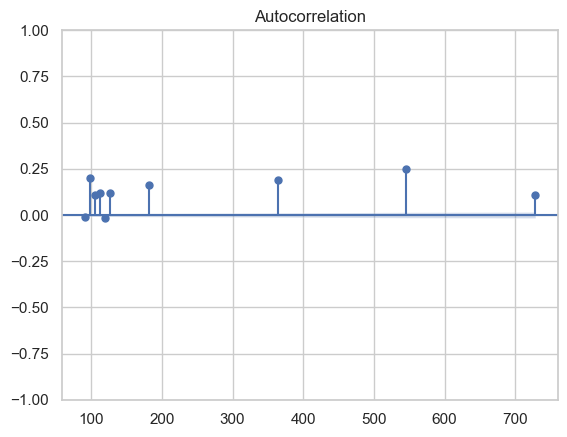

<Figure size 800x600 with 0 Axes>

In [55]:
acf = plot_acf(df_log['sales'], lags=lags)
fig = plt.figure()  
fig.set_size_inches(8, 6)

In [58]:
# pacf = plot_pacf(df_log['sales'], lags=lags)
# fig = plt.figure()  
# fig.set_size_inches(8, 6)

It is possible to see that the lags show significant correlation with sales. Especially the lag 546. 

# 5. Modelling
- In this step, I will train LightGBM model with the prepared data. Different preparation and modelling approaches will be tried here and I will stick with the best one, getting my final model. In order to obtain a more reliable performance measure, I will apply time series cross validation, explained before in this notebook.
- The enumeration represents a model tested with a specific data preparation approach. For example, in 4.2, I did the log transformation on sales variable. Thus, in 5.2, I will test LightGBM performance on this log transformed data. This represents the sequence of crisp-dm data preparation / modelling cycles.

### 5.1.0 Baseline Average Model
Before diving into machine learning techniques, I will assess the performance of an average model. If machine learning achieves a better result, it is suitable for this forecasting task, else our simple average prediction will compensate more.

In [ ]:
scores = time_series_cv(df_date, DummyRegressor(strategy='mean'), TEST_SIZE, GAP, TARGET, n_splits=5)

------------------------------------------------------------
DummyRegressor's time series cross validation results:
Average validation score = 31.1317
Standard deviation = 5.3142


### 5.1.1 Baseline LightGBM model
Now I will compare the average model performance with standard configurated LightGBM performance. If it presents a better result, machine learning is suitable for this forecasting task.

In [ ]:
scores = time_series_cv(df_date, LGBMRegressor(verbose=-1), TEST_SIZE, GAP, TARGET, n_splits=5)

------------------------------------------------------------
LGBMRegressor's time series cross validation results:
Average validation score = 9.365
Standard deviation = 0.9972


The baseline LightGBM model performance is better than the average model performance! Thus, machine learning is indeed suitable for the forecasting task and I will keep trying to enhance this baseline LGBMRegressor result.

### 5.2.0 Log transformation and lag features LightGBM model
Now I will assess wheter applying a log transformation to sales variable and adding lag features improve the model's performance.

In [64]:
scores = time_series_cv(df_log, LGBMRegressor(verbose=-1), TEST_SIZE, GAP, TARGET, n_splits=5, log=True)

------------------------------------------------------------
LGBMRegressor's time series cross validation results:
Average validation score = 8.556
Standard deviation = 0.7231


As expected, applying a log transformation to sales variable and adding lag features improved the model's performance.